# Exploración y Predicción de la Incidencia Delictiva en la CDMX (2015-2025)

![uami](./figuras/uami.png)

**Maestría en Matemáticas Aplicadas**

Alan Badillo Salas (cbi2242800355@xanum.uam.mx)

> Tópicos Selectos de Matemáticas Aplicadas II
> Análisis de Datos (2138002)
> 
> **Proyecto Final**
> 
> *Trimestre: 25-P*
>
> Profesor: Dr. Juan Alberto Martínez Cadena

## Librerías

In [454]:
import numpy
import pandas

import matplotlib.pyplot as pyplot
import seaborn

import folium
from folium.plugins import HeatMap

## Fase 1 - Preparación de los datos

Carga de los datos.

Fuente: [datos.gob.mx](https://datos.gob.mx/dataset/incidencia_delictiva)

[![fig1](figuras/fig1.png)](https://datos.gob.mx/dataset/incidencia_delictiva)

In [395]:
incidencias = pandas.read_csv("conjuntos/IDM_NM_jun25.csv", encoding="latin1")

incidencias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2562994 entries, 0 to 2562993
Data columns (total 21 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Año                     int64  
 1   Clave_Ent               int64  
 2   Entidad                 object 
 3   Cve. Municipio          int64  
 4   Municipio               object 
 5   Bien jurídico afectado  object 
 6   Tipo de delito          object 
 7   Subtipo de delito       object 
 8   Modalidad               object 
 9   Enero                   int64  
 10  Febrero                 int64  
 11  Marzo                   int64  
 12  Abril                   int64  
 13  Mayo                    int64  
 14  Junio                   int64  
 15  Julio                   float64
 16  Agosto                  float64
 17  Septiembre              float64
 18  Octubre                 float64
 19  Noviembre               float64
 20  Diciembre               float64
dtypes: float64(6), int64(9), object

Hay $2,562,994$ (dos millones, quinientos sesenta y dos mil, novecientos noventa y cuatro) registros de hecho delictivos ocurridos en México, entre el 2015 y junio del 2025.

### Conversión del formato ancho a largo

**Diagnóstico**: Se observa que cada fila codifica 12 columnas de los meses (Enero, ..., Diciembre)

**Estrategia**: Aplicar `melt` para extraer en formato largo los meses y luego fusionar los datos restantes

> Se observa que cada fila tiene 12 meses

In [396]:
incidencias.head()

,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Enero,...,Marzo,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre
0,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego,2,...,1,1,0,1,1.0,0.0,2.0,1.0,0.0,1.0
1,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma blanca,1,...,0,0,0,1,0.0,1.0,0.0,0.0,0.0,0.0
2,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con otro elemento,0,...,1,1,3,2,0.0,1.0,2.0,0.0,0.0,0.0
3,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,No especificado,1,...,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio culposo,Con arma de fuego,0,...,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0


> Se extraen las columnas 9, 10, ... (Enero, Febrero, ...)

En los últimos meses del 2025 no hay datos, por lo que se rellena a 0 y se determinan conteos enteros, además se guarda el índice de cada fila

In [397]:
meses_ancho = incidencias.iloc[:, 9:].fillna(0).astype(int)
meses_ancho["id"] = meses_ancho.index

meses_ancho.head()

,Enero,Febrero,Marzo,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre,id
0,2,0,1,1,0,1,1,0,2,1,0,1,0
1,1,1,0,0,0,1,0,1,0,0,0,0,1
2,0,0,1,1,3,2,0,1,2,0,0,0,2
3,1,0,0,1,0,0,0,0,0,0,0,0,3
4,0,0,0,0,1,0,0,0,0,0,0,0,4


> Aplicamos un `melt` para convertir cada fila al formato largo

* `id_vars` - Nombre de la columna con los índices
* `var_name` - Nombre de la columna de reducción (columnas contraídas)
* `var_value` - Nombre de la columna de los valores

In [398]:
meses_largo = meses_ancho.melt(id_vars="id", var_name="Mes", value_name="Total").set_index("id")

meses_largo.head()

,Mes,Total
id,,
0,Enero,2
1,Enero,1
2,Enero,0
3,Enero,1
4,Enero,0


In [399]:
meses_largo.shape

(30755928, 2)

**Diagnóstico:** Se tienen 30,755,928 registros, derivados de los meses en forma largo

**Estrategia:** Fusionar los datos originales con los meses en formato largo

In [400]:
delitos = meses_largo.join(incidencias.iloc[:, :9])

delitos.head()

,Mes,Total,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad
id,,,,,,,,,,,
0,Enero,2,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego
1,Enero,1,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma blanca
2,Enero,0,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con otro elemento
3,Enero,1,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,No especificado
4,Enero,0,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio culposo,Con arma de fuego


In [401]:
delitos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30755928 entries, 0 to 2562993
Data columns (total 11 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   Mes                     object
 1   Total                   int64 
 2   Año                     int64 
 3   Clave_Ent               int64 
 4   Entidad                 object
 5   Cve. Municipio          int64 
 6   Municipio               object
 7   Bien jurídico afectado  object
 8   Tipo de delito          object
 9   Subtipo de delito       object
 10  Modalidad               object
dtypes: int64(4), object(7)
memory usage: 2.7+ GB


Ahora se tienen $30,755,928$ (treinta millones, setecientos cincuenta y cinco mil, novecientos veintiocho) registros de hecho delictivos ocurridos en México, entre el 2015 y junio del 2025.

**Número de delitos registrados reales.**

In [402]:
delitos["Mes_num"] = delitos["Mes"].map({
    "Enero": 1,
    "Febrero": 2,
    "Marzo": 3,
    "Abril": 4,
    "Mayo": 5,
    "Junio": 6,
    "Julio": 7,
    "Agosto": 8,
    "Septiembre": 9,
    "Octubre": 10,
    "Noviembre": 11,
    "Diciembre": 12,
})

delitos.head()

,Mes,Total,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Mes_num
id,,,,,,,,,,,,
0,Enero,2,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego,1
1,Enero,1,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma blanca,1
2,Enero,0,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con otro elemento,1
3,Enero,1,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,No especificado,1
4,Enero,0,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio culposo,Con arma de fuego,1


### Total de Delitos por Entidad

In [403]:
reporte1 = delitos[["Entidad", "Total"]].groupby("Entidad").sum()
reporte1

,Total
Entidad,
Aguascalientes,371883
Baja California,1120676
Baja California Sur,234023
Campeche,85081
Chiapas,207315
Chihuahua,732127
Ciudad de México,2253145
Coahuila de Zaragoza,588000
Colima,243624


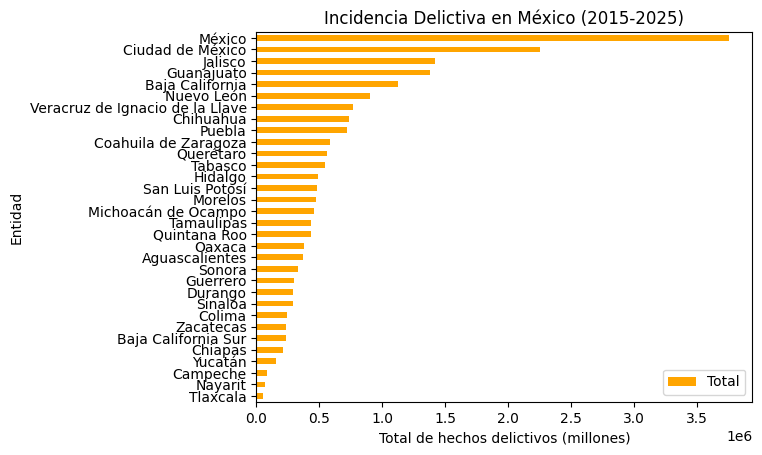

In [404]:
reporte1.sort_values(by="Total").plot.barh(color="orange")
pyplot.title("Incidencia Delictiva en México (2015-2025)")
pyplot.xlabel("Total de hechos delictivos (millones)")
pyplot.savefig("figuras/reporte1.png")
pyplot.show()

El Estado de México, la Ciudad de México, Jalisco, Guanajuato, Baja California y Nuevo León son las entidades con mayor número de hechos delictivos. Mientras que Tlaxcala, Nayarit, Campeche, Yucatán, Chiapas y Baja California Sur son las entidades con el menor número de hechos delictivos (ocurridos entre el 2015 y Junio del 2025).

### Análisis para la Ciudad de México

In [405]:
delitos_cdmx = delitos[delitos["Entidad"] == "Ciudad de México"].copy().reset_index()

delitos_cdmx.head()

,id,Mes,Total,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Mes_num
0,25970,Enero,4,2015,9,Ciudad de México,9002,Azcapotzalco,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego,1
1,25971,Enero,1,2015,9,Ciudad de México,9002,Azcapotzalco,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma blanca,1
2,25972,Enero,2,2015,9,Ciudad de México,9002,Azcapotzalco,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con otro elemento,1
3,25973,Enero,0,2015,9,Ciudad de México,9002,Azcapotzalco,La vida y la Integridad corporal,Homicidio,Homicidio doloso,No especificado,1
4,25974,Enero,0,2015,9,Ciudad de México,9002,Azcapotzalco,La vida y la Integridad corporal,Homicidio,Homicidio culposo,Con arma de fuego,1


In [406]:
delitos_cdmx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219912 entries, 0 to 219911
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   id                      219912 non-null  int64 
 1   Mes                     219912 non-null  object
 2   Total                   219912 non-null  int64 
 3   Año                     219912 non-null  int64 
 4   Clave_Ent               219912 non-null  int64 
 5   Entidad                 219912 non-null  object
 6   Cve. Municipio          219912 non-null  int64 
 7   Municipio               219912 non-null  object
 8   Bien jurídico afectado  219912 non-null  object
 9   Tipo de delito          219912 non-null  object
 10  Subtipo de delito       219912 non-null  object
 11  Modalidad               219912 non-null  object
 12  Mes_num                 219912 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 21.8+ MB


Hay $219,912$ (docientos diescinueve mil, novecientos doce) registros.

> Solo delitos de la Ciudad de México

In [407]:
delitos_cdmx.to_csv("conjuntos/delitos_cdmx.csv", index=False)

## Fase 2 - Análisis exploratorio

In [408]:
delitos_cdmx = pandas.read_csv("conjuntos/delitos_cdmx.csv")

delitos_cdmx.head()

,id,Mes,Total,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Mes_num
0,25970,Enero,4,2015,9,Ciudad de México,9002,Azcapotzalco,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego,1
1,25971,Enero,1,2015,9,Ciudad de México,9002,Azcapotzalco,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma blanca,1
2,25972,Enero,2,2015,9,Ciudad de México,9002,Azcapotzalco,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con otro elemento,1
3,25973,Enero,0,2015,9,Ciudad de México,9002,Azcapotzalco,La vida y la Integridad corporal,Homicidio,Homicidio doloso,No especificado,1
4,25974,Enero,0,2015,9,Ciudad de México,9002,Azcapotzalco,La vida y la Integridad corporal,Homicidio,Homicidio culposo,Con arma de fuego,1


In [409]:
reporte2 = delitos_cdmx[["Entidad", "Total"]].groupby("Entidad").sum()
reporte2

,Total
Entidad,
Ciudad de México,2253145


Se registraron un total de $2,253,145$ (dos millones, doscientos cincuenta y tres mil, ciento cuarenta y cinco) hecho delictivos en la Ciudad de México, ocurridos entre el 2015 y junio del 2025.

### Incidencia Delictiva en la Ciudad de México por Alcaldía (2015-2025)

In [410]:
reporte3 = delitos_cdmx[["Municipio", "Total"]].groupby("Municipio").sum().sort_values("Total")
reporte3

,Total
Municipio,
Milpa Alta,19627
No Especificado,23769
Cuajimalpa de Morelos,36331
La Magdalena Contreras,39872
Tláhuac,62452
Xochimilco,74156
Iztacalco,97760
Azcapotzalco,108480
Venustiano Carranza,126474


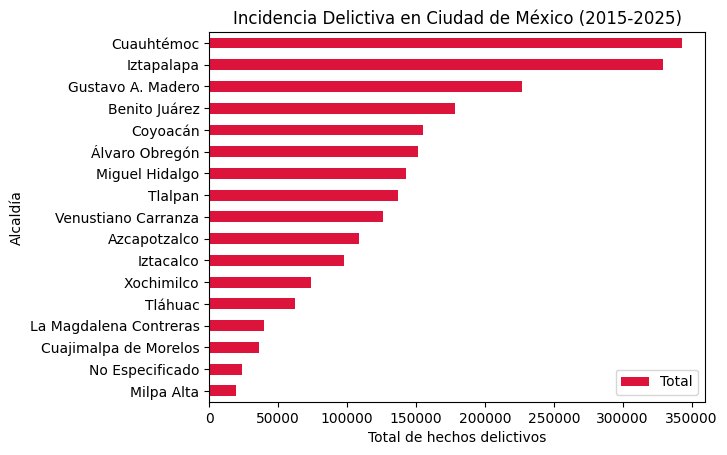

In [411]:
reporte3.plot.barh(color="crimson")
pyplot.title("Incidencia Delictiva en Ciudad de México (2015-2025)")
pyplot.xlabel("Total de hechos delictivos")
pyplot.ylabel("Alcaldía")
pyplot.savefig("figuras/reporte3.png")
pyplot.show()

Las alcaldías de Cuahtémoc, Iztapalapa y Gustavo A. Madero son las que tienen mayor número de incidentes delictivos, mientras que Milpa Alta, Cuajimalpa de Morelos y la Magdalena Contreras son las de menor incidencia (del 2015 a junio del 2025).

> Análisis por año

In [412]:
reporte4 = delitos_cdmx[["Año", "Municipio", "Total"]].groupby(["Año", "Municipio"]).sum().sort_values("Total").unstack().droplevel(axis=1, level=0).T
reporte4["2025*"] = 2 * reporte4[2025]
del reporte4[2025]
reporte4["Total"] = reporte4.sum(axis=1)
reporte4 = reporte4.sort_values("Total")
reporte4

Año,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025*,Total
Municipio,,,,,,,,,,,,
Milpa Alta,1163,1080,1303,1708,1641,1711,2371,2646,2369,2449,2372,20813
No Especificado,547,896,609,985,0,47,597,585,7340,8065,8196,27867
Cuajimalpa de Morelos,2560,2657,2857,3326,3787,3251,3872,3980,4294,3894,3706,38184
La Magdalena Contreras,2330,2811,3016,3471,4007,3959,4397,4652,4823,4533,3746,41745
Tláhuac,3589,3901,4765,5724,6000,5761,7007,7638,7691,6952,6848,65876
Xochimilco,6021,5947,6472,7385,7440,6854,7503,7956,7931,7251,6792,77552
Iztacalco,7342,7397,8700,10502,10244,7908,9287,11015,10466,9941,9916,102718
Azcapotzalco,8879,9509,10676,11889,10822,10110,11298,11555,10201,9353,8376,112668
Venustiano Carranza,9156,9696,10930,13875,14419,11487,12644,12973,13174,12295,11650,132299


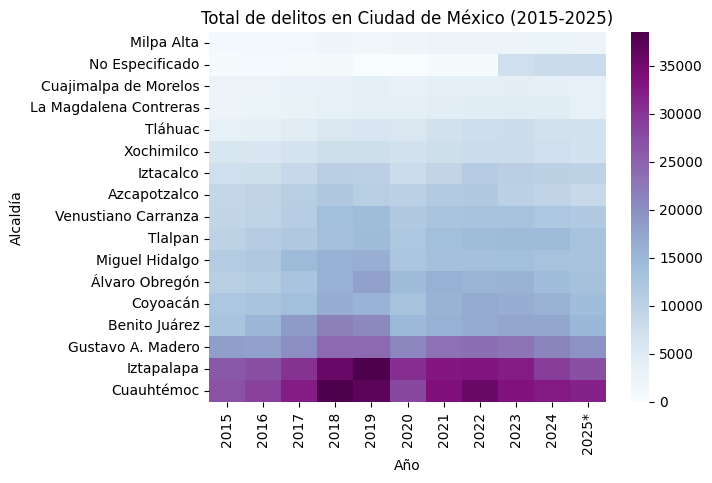

In [413]:
seaborn.heatmap(reporte4.iloc[:,:-1], cmap="BuPu")
pyplot.title("Total de delitos en Ciudad de México (2015-2025)")
pyplot.xlabel("Año")
pyplot.ylabel("Alcaldía")
pyplot.xticks(rotation=90)
pyplot.savefig("figuras/reporte4.png")
pyplot.show()

Se observa un patrón de bajas en el año $2020$, toda una franja de color más suave (bajo), lo que significa una disminución de los delitos en todas las alcadías, explicada por la pandemia del COVID-19.

**Nota:** Se ajustaron los datos del año $2025$ en un múltiplo de 2, ya que los datos llegan a junio.

### Tendencia anual y mensual

> Análisis temporal (año y mes) del total de delitos

In [414]:
reporte5 = delitos_cdmx[["Año", "Mes_num", "Total"]].groupby(["Año", "Mes_num"]).sum().reset_index()
reporte5 = reporte5[reporte5["Total"] > 0]
reporte5.index = pandas.PeriodIndex.from_fields(year=reporte5["Año"], month=reporte5["Mes_num"], freq="M")
del reporte5["Año"]
del reporte5["Mes_num"]

reporte5.head()

,Total
2015-01,12202
2015-02,12433
2015-03,14271
2015-04,13882
2015-05,14250


In [415]:
reporte6 = reporte5.groupby(reporte5.index.year).sum()
reporte6.loc[2025] = 2 * reporte6.loc[2025]
index = list(reporte6.index)
index[-1] = "2025*"
reporte6.index = index
reporte6

,Total
2015,169701
2016,179720
2017,204078
2018,241029
2019,242838
2020,198155
2021,223742
2022,232644
2023,234474
2024,222351


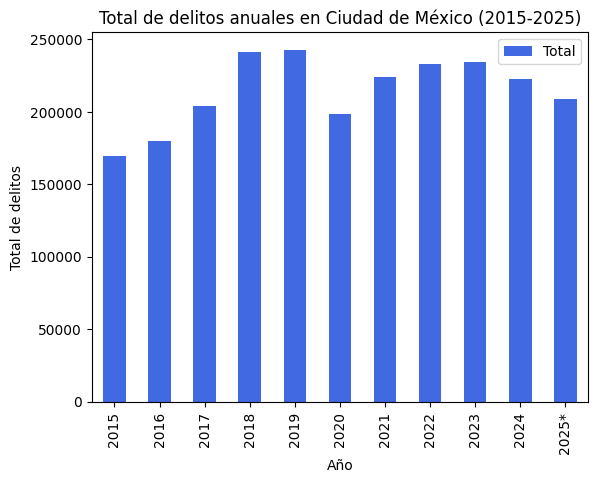

In [416]:
reporte6.plot.bar(color="royalblue")
# reporte6.plot(marker=".", linestyle=":", mfc="red", mec="crimson", figsize=(15, 5))
pyplot.title("Total de delitos anuales en Ciudad de México (2015-2025)")
pyplot.xlabel("Año")
pyplot.ylabel("Total de delitos")
pyplot.savefig("figuras/reporte6.png")
pyplot.show()

In [417]:
reporte7 = reporte5.copy()
reporte7.index = reporte7.index.to_timestamp()
reporte7 = reporte7.resample("MS").sum()
reporte7

,Total
2015-01-01,12202
2015-02-01,12433
2015-03-01,14271
2015-04-01,13882
2015-05-01,14250
...,...
2025-02-01,16163
2025-03-01,18552
2025-04-01,17690
2025-05-01,18536


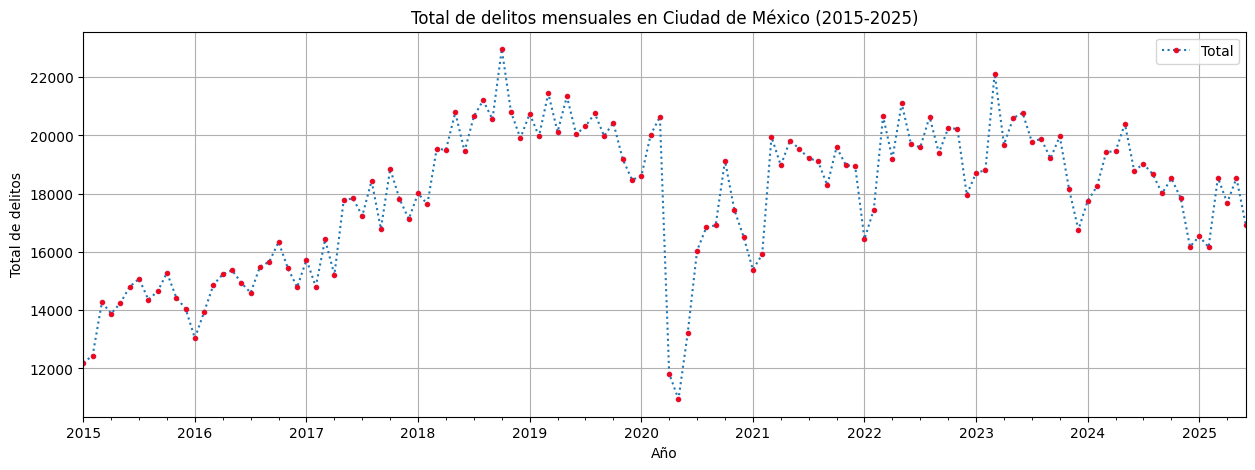

In [418]:
reporte7.plot(marker=".", linestyle=":", mfc="red", mec="crimson", figsize=(15, 5))
pyplot.title("Total de delitos mensuales en Ciudad de México (2015-2025)")
pyplot.xlabel("Año")
pyplot.ylabel("Total de delitos")
# pyplot.ylim(0, reporte7["Total"].max() + 5_000)
pyplot.grid()
pyplot.savefig("figuras/reporte7.png")
pyplot.show()

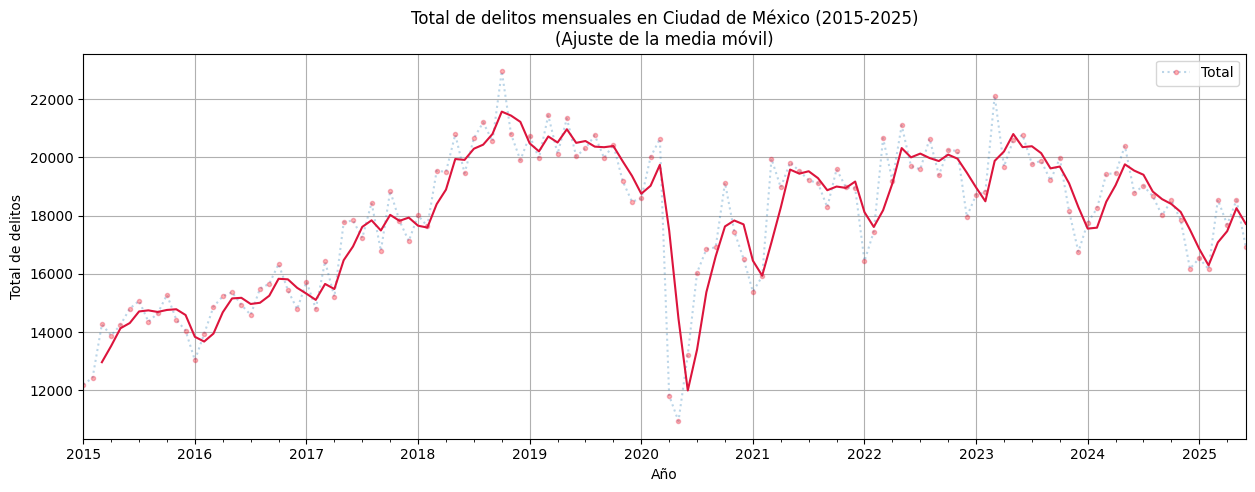

In [419]:
reporte8 = reporte7.copy()
s = reporte8["Total"].rolling(window=3).mean()
reporte8.plot(marker=".", linestyle=":", mfc="red", mec="crimson", figsize=(15, 5), alpha=0.3)
pandas.Series(s).plot(color="crimson")
pyplot.title("Total de delitos mensuales en Ciudad de México (2015-2025)\n(Ajuste de la media móvil)")
pyplot.xlabel("Año")
pyplot.ylabel("Total de delitos")
# pyplot.ylim(0, reporte7["Total"].max() + 5_000)
pyplot.grid()
pyplot.savefig("figuras/reporte8.png")
pyplot.show()

Se observa que los delitos bajan a principios de año (se podría deber a que hay más operativos policiacos entre el 24 de diciembre y el primero de enero), y se corrobora que los delitos bajaron en 2020 cuando fue anunciada la llegada de la pandemia COVID-19 a México.

### Tipos de delitos

In [420]:
reporte9 = delitos_cdmx[["Tipo de delito", "Subtipo de delito", "Total"]].groupby(["Tipo de delito", "Subtipo de delito"]).sum().sort_values("Total")
reporte9

Total
Tipo de delito                                     Subtipo de delito                                         
Robo                                               Robo de ganado                                           0
Violencia de género en todas sus modalidades di... Violencia de género en todas sus modalidades di...       0
Hostigamiento sexual                               Hostigamiento sexual                                     0
Incesto                                            Incesto                                                  2
Tráfico de menores                                 Tráfico de menores                                      24
Rapto                                              Rapto                                                   62
Evasión de presos                                  Evasión de presos                                      162
Robo                                               Robo de maquinaria                                     166
                                                   Robo a institución bancaria                            214
Feminicidio                                        Feminicidio                                            623
Secuestro                                          Secuestro                                              812
Trata de personas                                  Trata de personas                                     1005
Aborto                                             Aborto                                                1427
Robo                                               Robo a transportista                                  1474
Corrupción de menores                              Corrupción de menores                                 2672
Electorales                                        Electorales                                           2823
Otros delitos contra la familia                    Otros delitos contra la familia                       2883
Robo                                               Robo en transporte público individual                 5155
Falsedad                                           Falsedad                                              5615
Extorsión                                          Extorsión                                             5974
Otros delitos que atentan contra la vida y la i... Otros delitos que atentan contra la vida y la i...    6328
Homicidio                                          Homicidio culposo                                     7330
Violación equiparada                               Violación equiparada                                  8019
Incumplimiento de obligaciones de asistencia fa... Incumplimiento de obligaciones de asistencia fa...    8340
Allanamiento de morada                             Allanamiento de morada                                8398
Otros delitos que atentan contra la libertad y ... Otros delitos que atentan contra la libertad y ...    8778
Violación simple                                   Violación simple                                      8966
Contra el medio ambiente                           Contra el medio ambiente                              9245
Acoso sexual                                       Acoso sexual                                          9882
Homicidio                                          Homicidio doloso                                     10240
Otros delitos contra la sociedad                   Otros delitos contra la sociedad                     12744
Otros delitos que atentan contra la libertad pe... Otros delitos que atentan contra la libertad pe...   15314
Robo                                               Robo a transeúnte en espacio abierto al público      18667
                                                   Robo en transporte individual                        22631
Otros delitos contra el patrimonio                 Otros delitos contra el patrimonio                   29111
Abuso sexual                      

**Diagnóstico:** Hay 44 tipos de delitos y 55 subtipos, la mayoría corresponde su tipo y subtipo

**Estrategia:** Se tomarán solo los subtipos y se hará una reclasificación de los grupos de delitos

> Grupos de subtipos de delitos

🔐 Grupo: Robos (13 delitos)
- Robo de ganado
- Robo de maquinaria
- Robo a institución bancaria
- Robo a transportista
- Robo en transporte público individual
- Robo en transporte público colectivo
- Robo en transporte individual
- Robo a transeúnte en espacio abierto al público
- Robo a casa habitación
- Robo de autopartes
- Robo de vehículo automotor
- Robo a transeúnte en vía pública
- Robo a negocio
- Otros robos

💸 Grupo: Fraude, falsificación y confianza (5 delitos)
- Abuso de confianza
- Fraude
- Falsificación
- Extorsión
- Despojo

🧑‍⚖️ Grupo: Delitos sexuales (7 delitos)
- Acoso sexual
- Abuso sexual
- Hostigamiento sexual
- Violación simple
- Violación equiparada
- Incesto
- Feminicidio

🧑‍🧒 Grupo: Familia, género y personas vulnerables (6 delitos)
- Violencia familiar
- Violencia de género en todas sus modalidades distinta a la violencia familiar
- Corrupción de menores
- Amenazas

☠️ Grupo: Contra la vida e integridad (6 delitos)
- Homicidio doloso
- Homicidio culposo
- Lesiones dolosas
- Lesiones culposas
- Otros delitos que atentan contra la vida y la integridad corporal
- Aborto

👮 Grupo: Contra la libertad personal (4 delitos)
- Secuestro
- Allanamiento de morada
- Otros delitos que atentan contra la libertad y la seguridad sexual
- Otros delitos que atentan contra la libertad personal
- Tráfico de menores
- Rapto
- Trata de personas

🧑‍⚖️ Grupo: Delitos contra la autoridad y la fe pública (4 delitos)
- Delitos cometidos por servidores públicos
- Electorales
- Falsedad
- Evasión de presos
- Narcomenudeo

🌳 Grupo: Sociedad y medio ambiente (4 delitos)
- Contra el medio ambiente
- Daño a la propiedad
- Otros delitos contra la sociedad
- Otros delitos del Fuero Común

🏛️ Grupo: Otros delitos contra estructuras sociales (3 delitos)
- Incumplimiento de obligaciones de asistencia familiar
- Otros delitos contra la familia
- Otros delitos contra el patrimonio

In [421]:
grupo_delito = {
    "Robos": [
        "Robo de ganado",
        "Robo de maquinaria",
        "Robo a institución bancaria",
        "Robo a transportista",
        "Robo en transporte público individual",
        "Robo en transporte público colectivo",
        "Robo en transporte individual",
        "Robo a transeúnte en espacio abierto al público",
        "Robo a casa habitación",
        "Robo de autopartes",
        "Robo de vehículo automotor",
        "Robo a transeúnte en vía pública",
        "Robo a negocio",
        "Otros robos",
    ],
    "Fraude": [
        "Abuso de confianza",
        "Fraude",
        "Falsificación",
        "Extorsión",
        "Despojo",
    ],
    "Sexuales": [
        "Acoso sexual",
        "Abuso sexual",
        "Hostigamiento sexual",
        "Violación simple",
        "Violación equiparada",
        "Incesto",
        "Feminicidio",
    ],
    "Personas": [
        "Violencia familiar",
        "Violencia de género en todas sus modalidades distinta a la violencia familiar",
        "Corrupción de menores",
        "Amenazas",
    ],
    "Homicidios": [
        "Homicidio doloso",
        "Homicidio culposo",
        "Lesiones dolosas",
        "Lesiones culposas",
        "Otros delitos que atentan contra la vida y la integridad corporal",
        "Aborto",
    ],
    "Secuestro": [
        "Secuestro",
        "Allanamiento de morada",
        "Otros delitos que atentan contra la libertad y la seguridad sexual",
        "Otros delitos que atentan contra la libertad personal",
        "Tráfico de menores",
        "Rapto",
        "Trata de personas",
    ],
    "Gobierno": [
        "Delitos cometidos por servidores públicos",
        "Electorales",
        "Falsedad",
        "Evasión de presos",
        "Narcomenudeo"
    ],
    "Ambiente": [
        "Contra el medio ambiente",
        "Daño a la propiedad",
        "Otros delitos contra la sociedad",
        "Otros delitos del Fuero Común",
    ],
    "Sociales": [
        "Incumplimiento de obligaciones de asistencia familiar",
        "Otros delitos contra la familia",
        "Otros delitos contra el patrimonio",
    ],
}

In [422]:
delitos_cdmx["grupo_delito"] = "NA"

for i in delitos_cdmx.index:
    subtipo = delitos_cdmx.loc[i, "Subtipo de delito"]
    for grupo in grupo_delito:
        if subtipo in grupo_delito[grupo]:
            delitos_cdmx.loc[i, "grupo_delito"] = grupo

delitos_cdmx.head()

,id,Mes,Total,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Mes_num,grupo_delito
0,25970,Enero,4,2015,9,Ciudad de México,9002,Azcapotzalco,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego,1,Homicidios
1,25971,Enero,1,2015,9,Ciudad de México,9002,Azcapotzalco,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma blanca,1,Homicidios
2,25972,Enero,2,2015,9,Ciudad de México,9002,Azcapotzalco,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con otro elemento,1,Homicidios
3,25973,Enero,0,2015,9,Ciudad de México,9002,Azcapotzalco,La vida y la Integridad corporal,Homicidio,Homicidio doloso,No especificado,1,Homicidios
4,25974,Enero,0,2015,9,Ciudad de México,9002,Azcapotzalco,La vida y la Integridad corporal,Homicidio,Homicidio culposo,Con arma de fuego,1,Homicidios


> Verificación de grupos no válidos

In [423]:
delitos_cdmx[delitos_cdmx["grupo_delito"] == "NA"]["Subtipo de delito"].unique()

array([], dtype=object)

> Versión con grupos manuales

In [424]:
delitos_cdmx.to_csv("conjuntos/delitos_cdmx_grupo.csv", index=False)

> Concentrado para grupo de delitos (General)

Homicidios


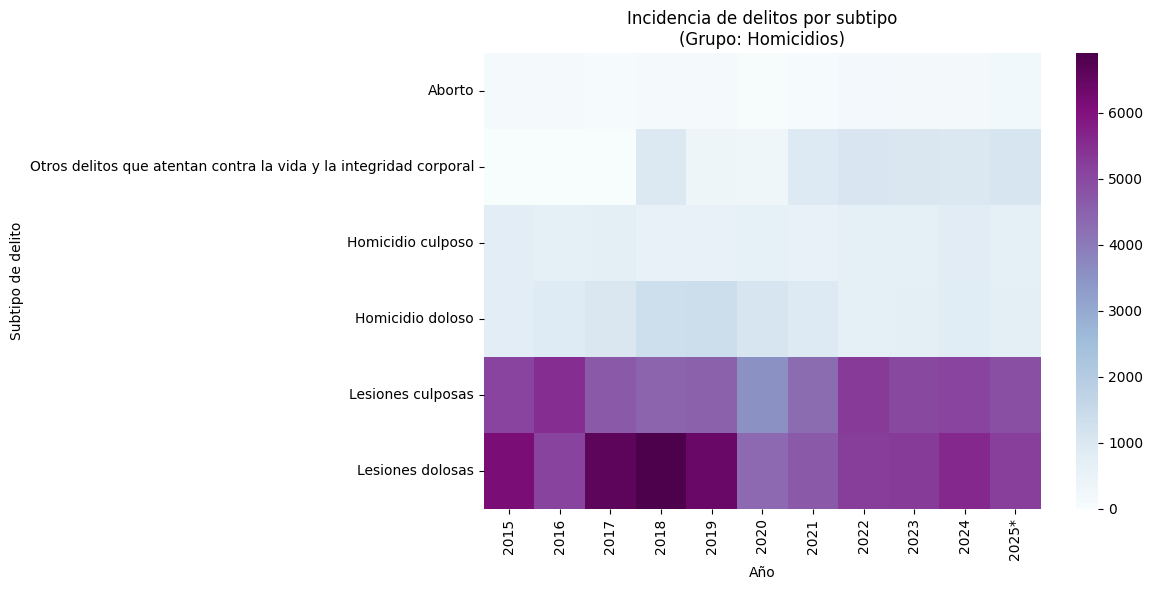

Sexuales


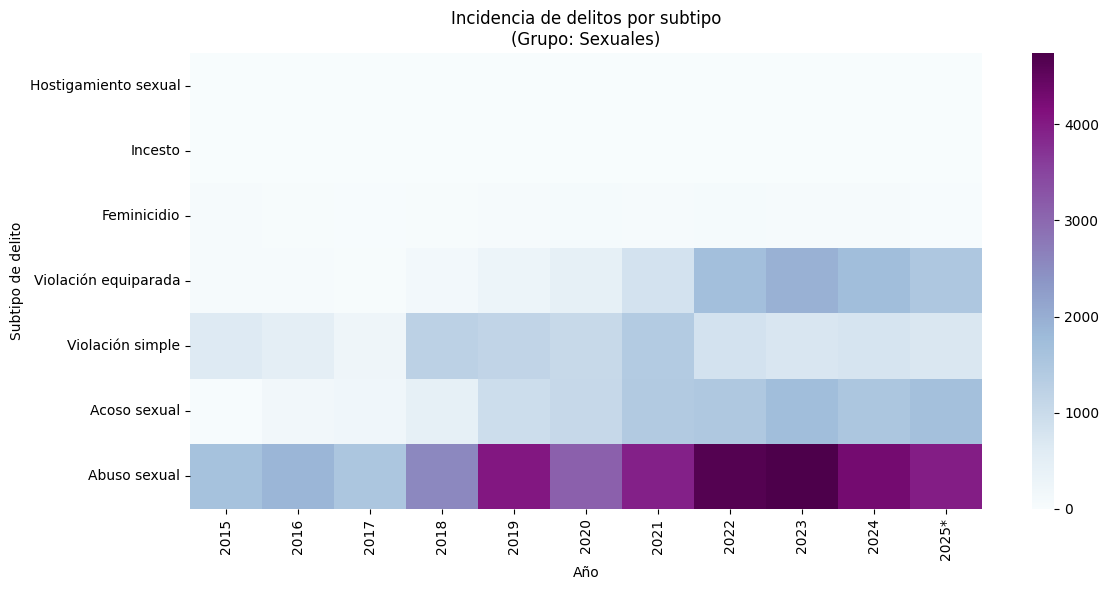

Secuestro


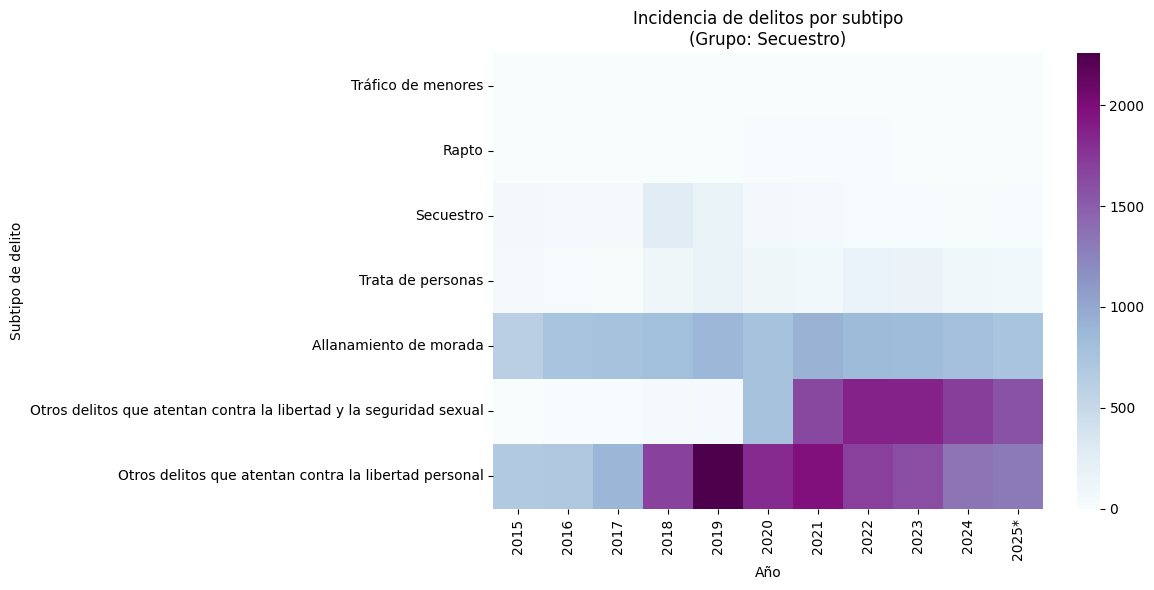

Robos


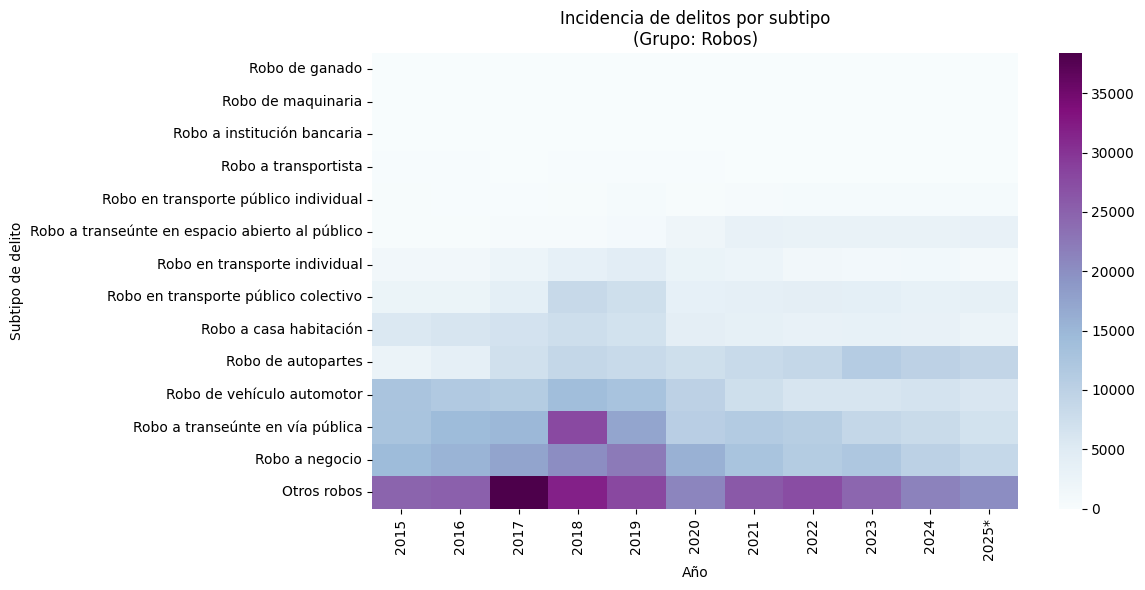

Fraude


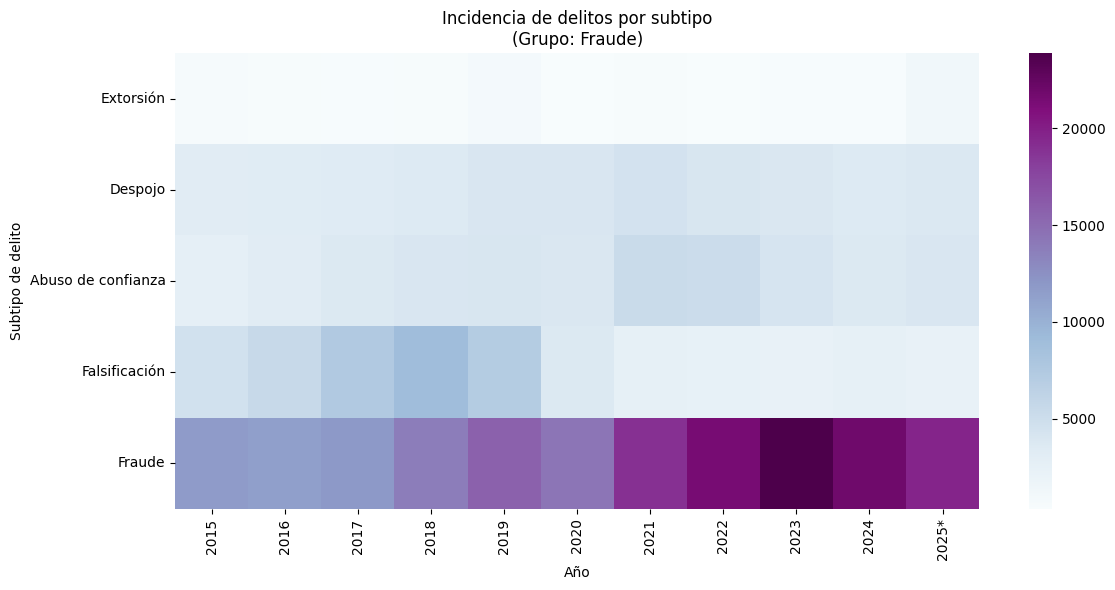

Ambiente


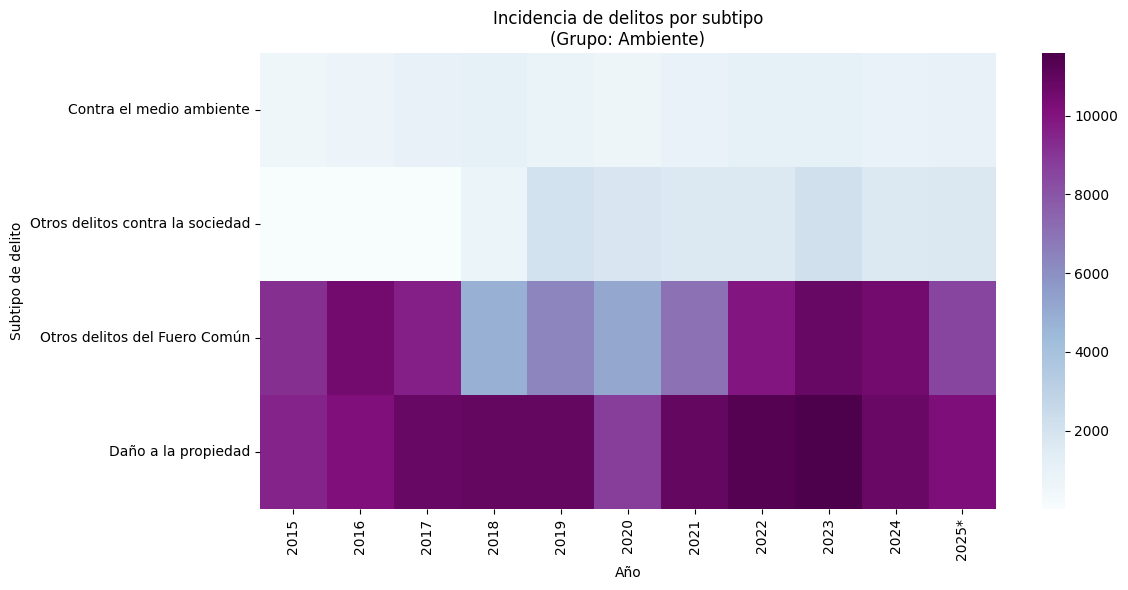

Sociales


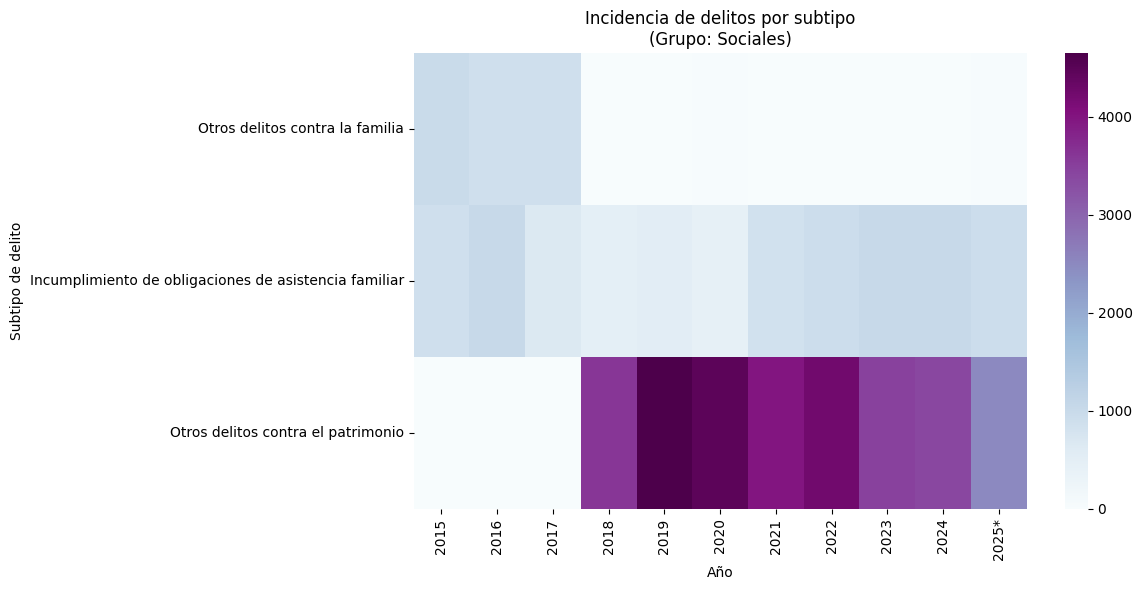

Personas


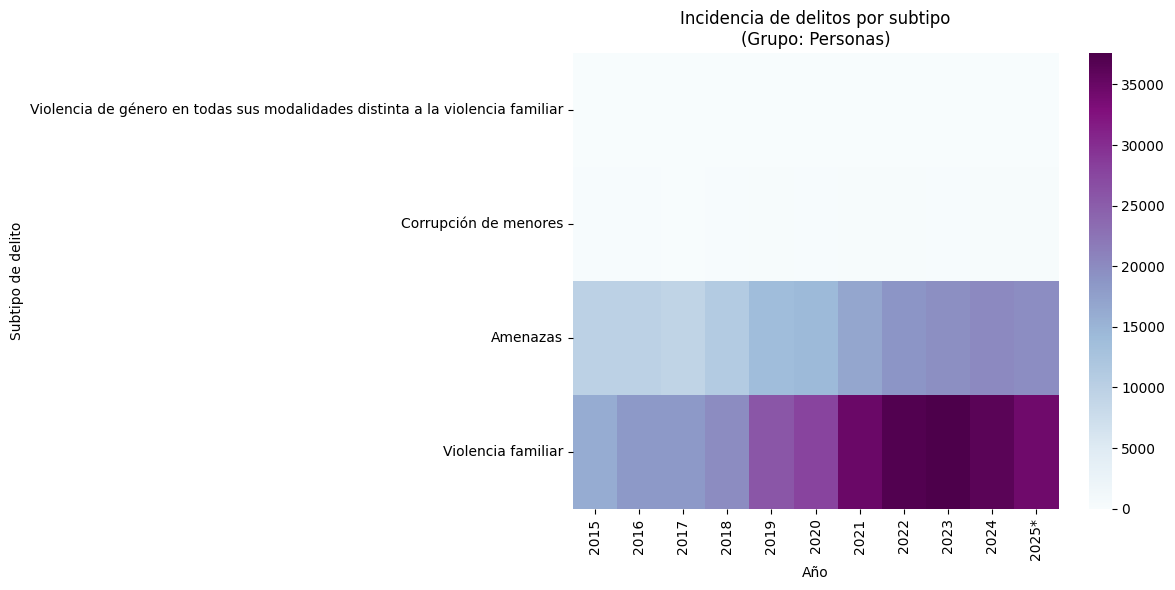

Gobierno


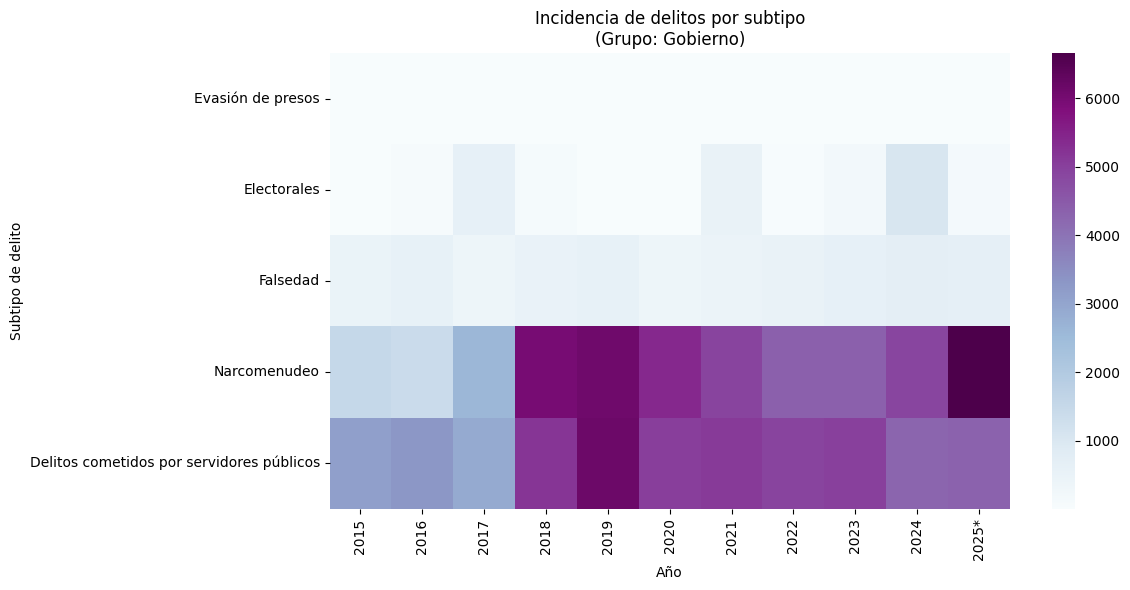

In [425]:
for grupo in delitos_cdmx["grupo_delito"].unique():
    print(grupo)
    reporte_sub = delitos_cdmx[delitos_cdmx["grupo_delito"] == grupo][["Año", "Subtipo de delito", "Total"]].groupby(["Año", "Subtipo de delito"]).sum().unstack().droplevel(axis=1, level=0).T
    reporte_sub[2025] = reporte_sub[2025] * 2
    columns = list(reporte_sub.columns)
    columns[-1] = "2025*"
    reporte_sub.columns = columns
    reporte_sub["Total"] = reporte_sub.sum(axis=1)
    reporte_sub = reporte_sub.sort_values("Total")
    reporte_sub = reporte_sub.iloc[:, :-1]
    # print(reporte_sub)
    pyplot.figure(figsize=(12, 6))
    seaborn.heatmap(reporte_sub, cmap="BuPu")
    pyplot.title(f"Incidencia de delitos por subtipo\n(Grupo: {grupo})")
    pyplot.xlabel("Año")
    pyplot.xticks(rotation=90)
    pyplot.tight_layout()
    pyplot.savefig(f"figuras/delitos_{grupo.lower()}_general.png")
    pyplot.show()
    print("=" * 80)


> Concentrado para grupo de delitos (Por Año)

Homicidios


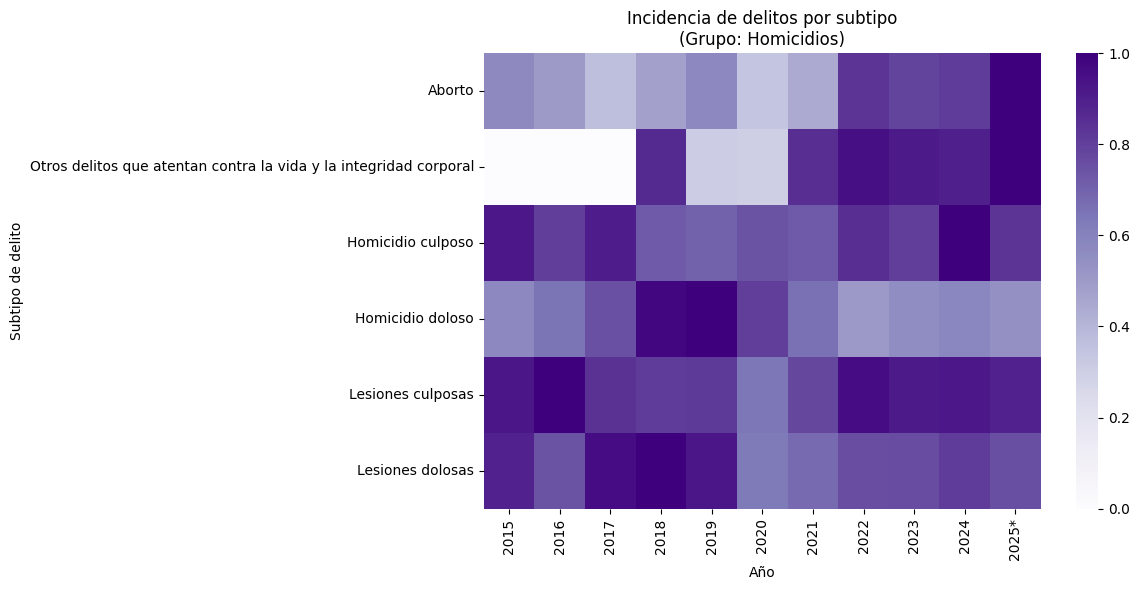

Sexuales


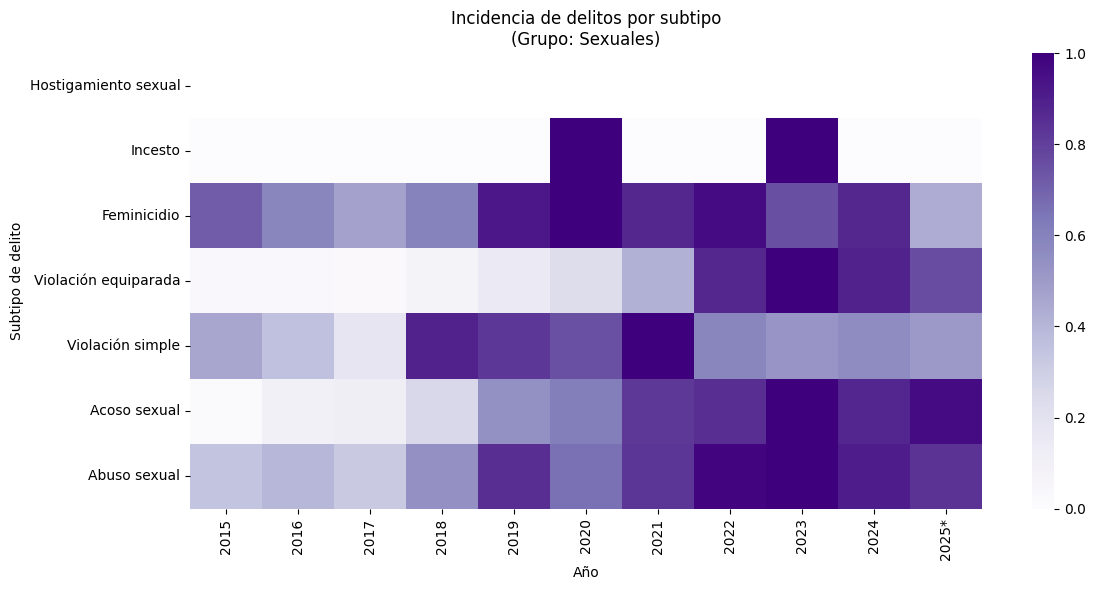

Secuestro


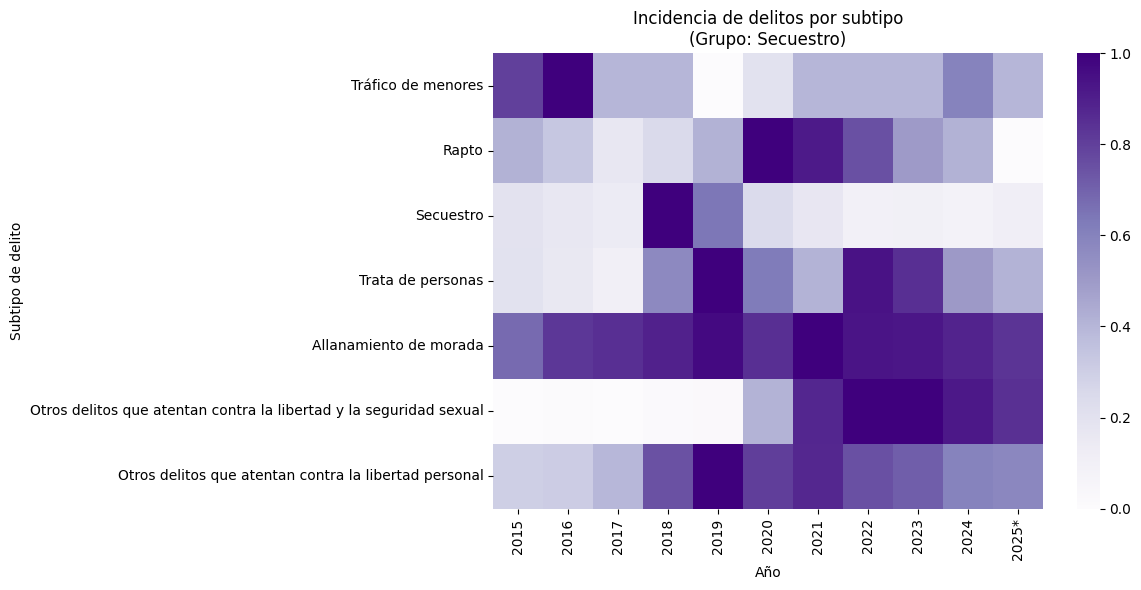

Robos


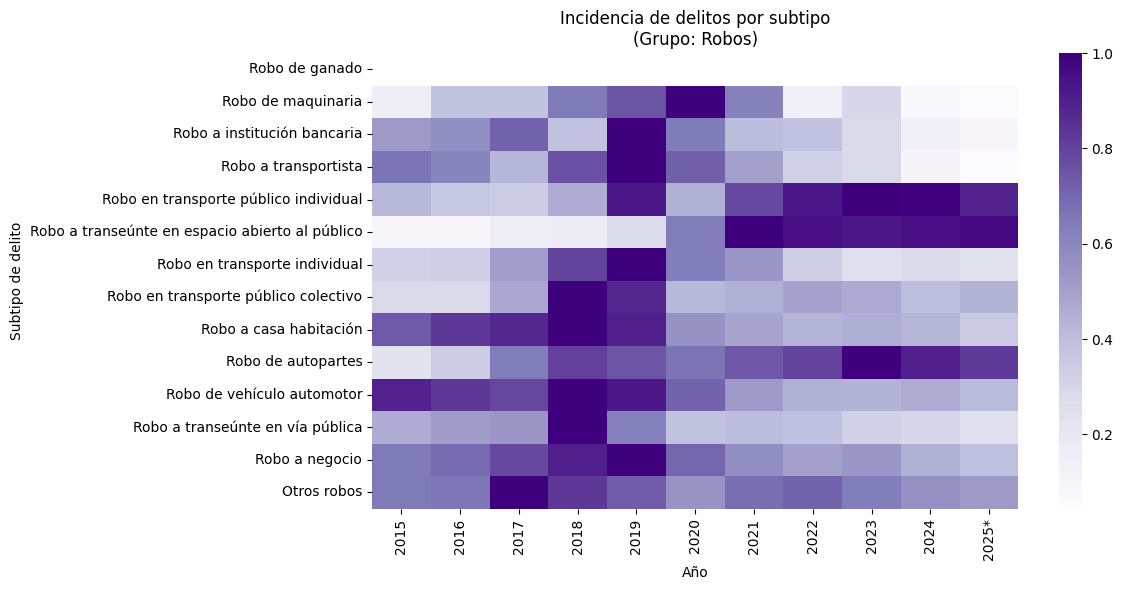

Fraude


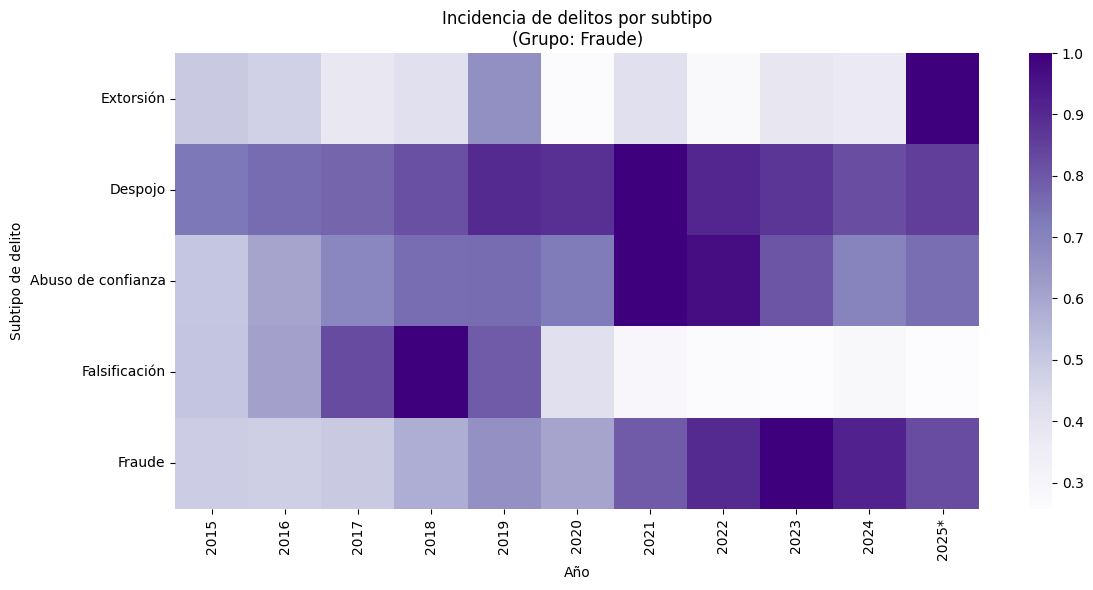

Ambiente


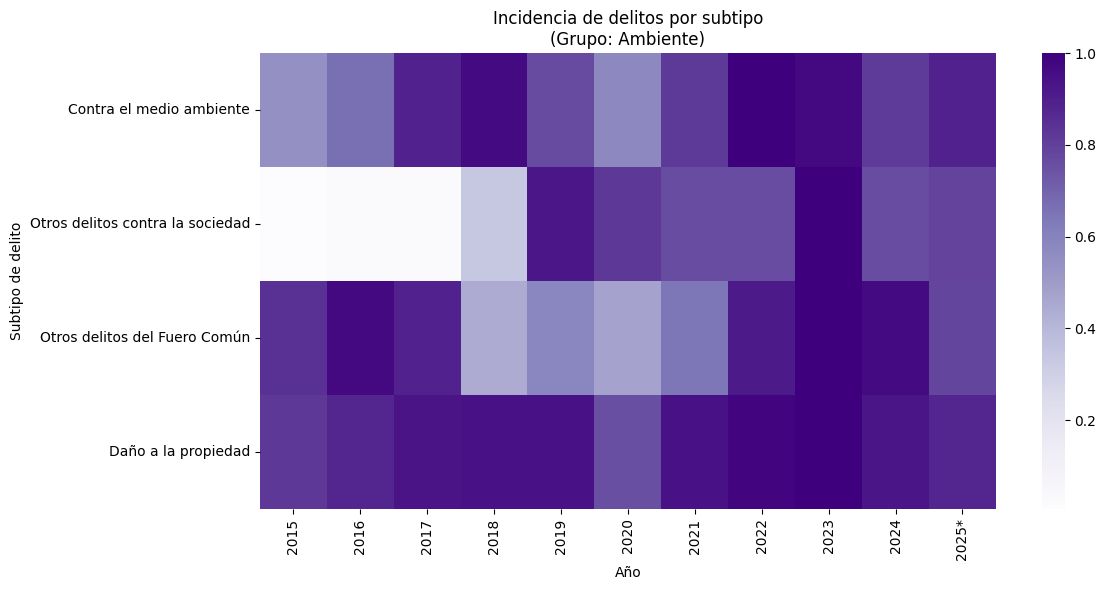

Sociales


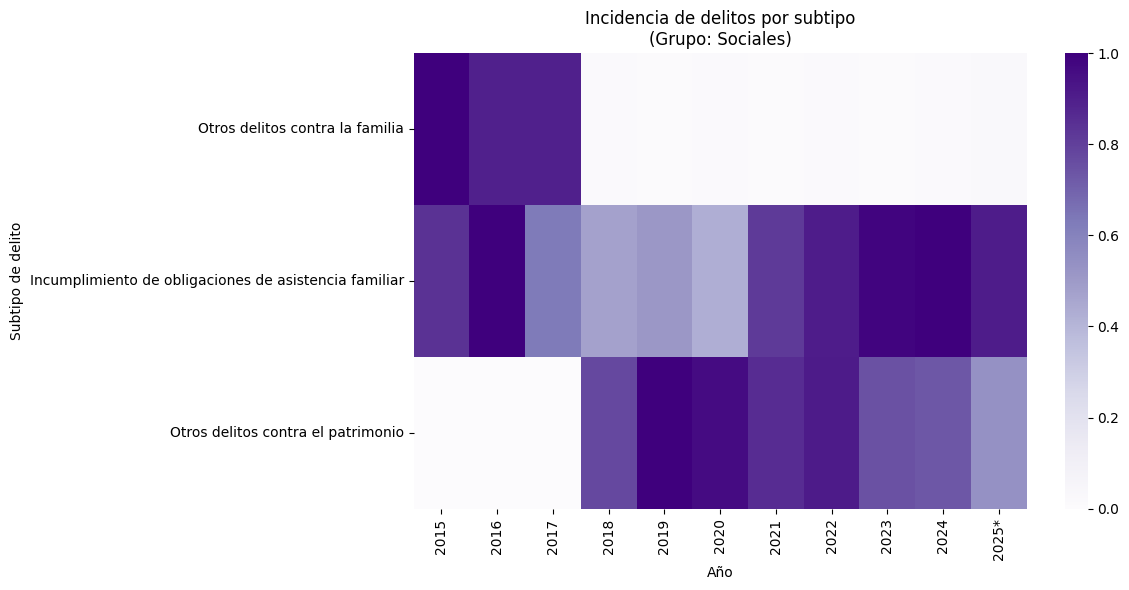

Personas


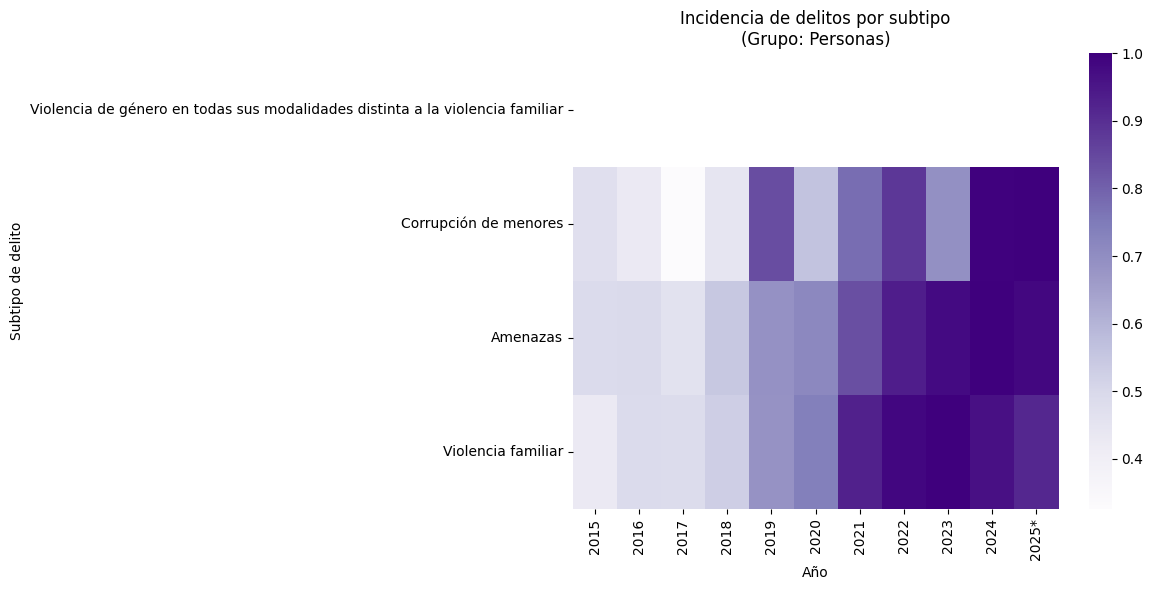

Gobierno


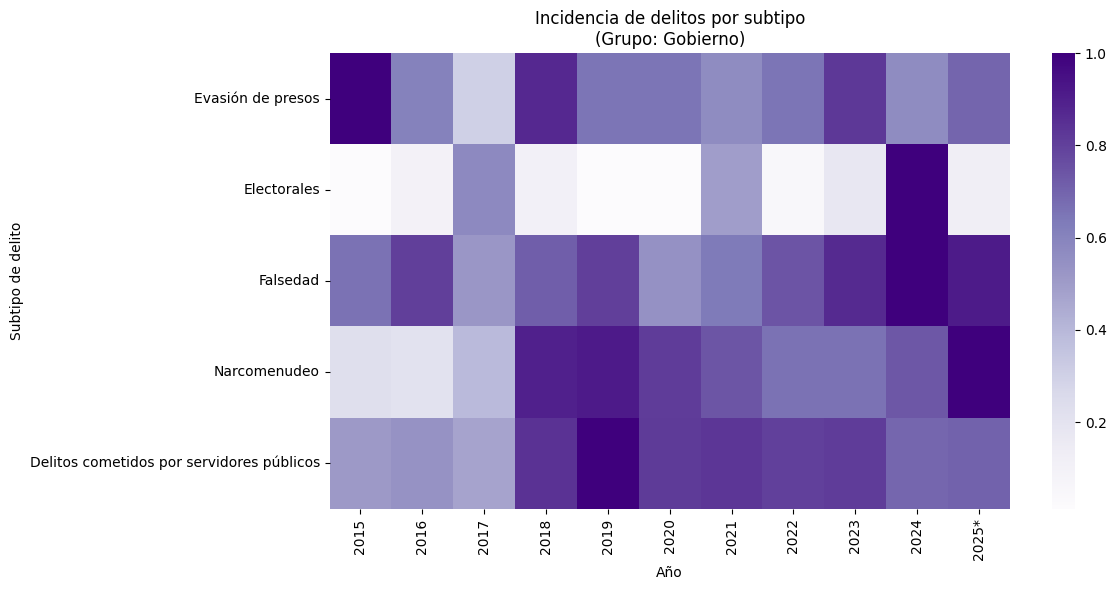

In [426]:
for grupo in delitos_cdmx["grupo_delito"].unique():
    print(grupo)
    reporte_sub = delitos_cdmx[delitos_cdmx["grupo_delito"] == grupo][["Año", "Subtipo de delito", "Total"]].groupby(["Año", "Subtipo de delito"]).sum().unstack().droplevel(axis=1, level=0).T
    reporte_sub[2025] = reporte_sub[2025] * 2
    columns = list(reporte_sub.columns)
    columns[-1] = "2025*"
    reporte_sub.columns = columns
    reporte_sub["Total"] = reporte_sub.sum(axis=1)
    reporte_sub = reporte_sub.sort_values("Total")
    reporte_sub = reporte_sub.iloc[:, :-1]
    reporte_sub = reporte_sub.div(reporte_sub.max(axis=1), axis=0)
    # print(reporte_sub)
    pyplot.figure(figsize=(12, 6))
    seaborn.heatmap(reporte_sub, cmap="Purples")
    pyplot.title(f"Incidencia de delitos por subtipo\n(Grupo: {grupo})")
    pyplot.xlabel("Año")
    pyplot.xticks(rotation=90)
    pyplot.tight_layout()
    pyplot.savefig(f"figuras/delitos_{grupo.lower()}_año.png")
    pyplot.show()
    print("=" * 80)


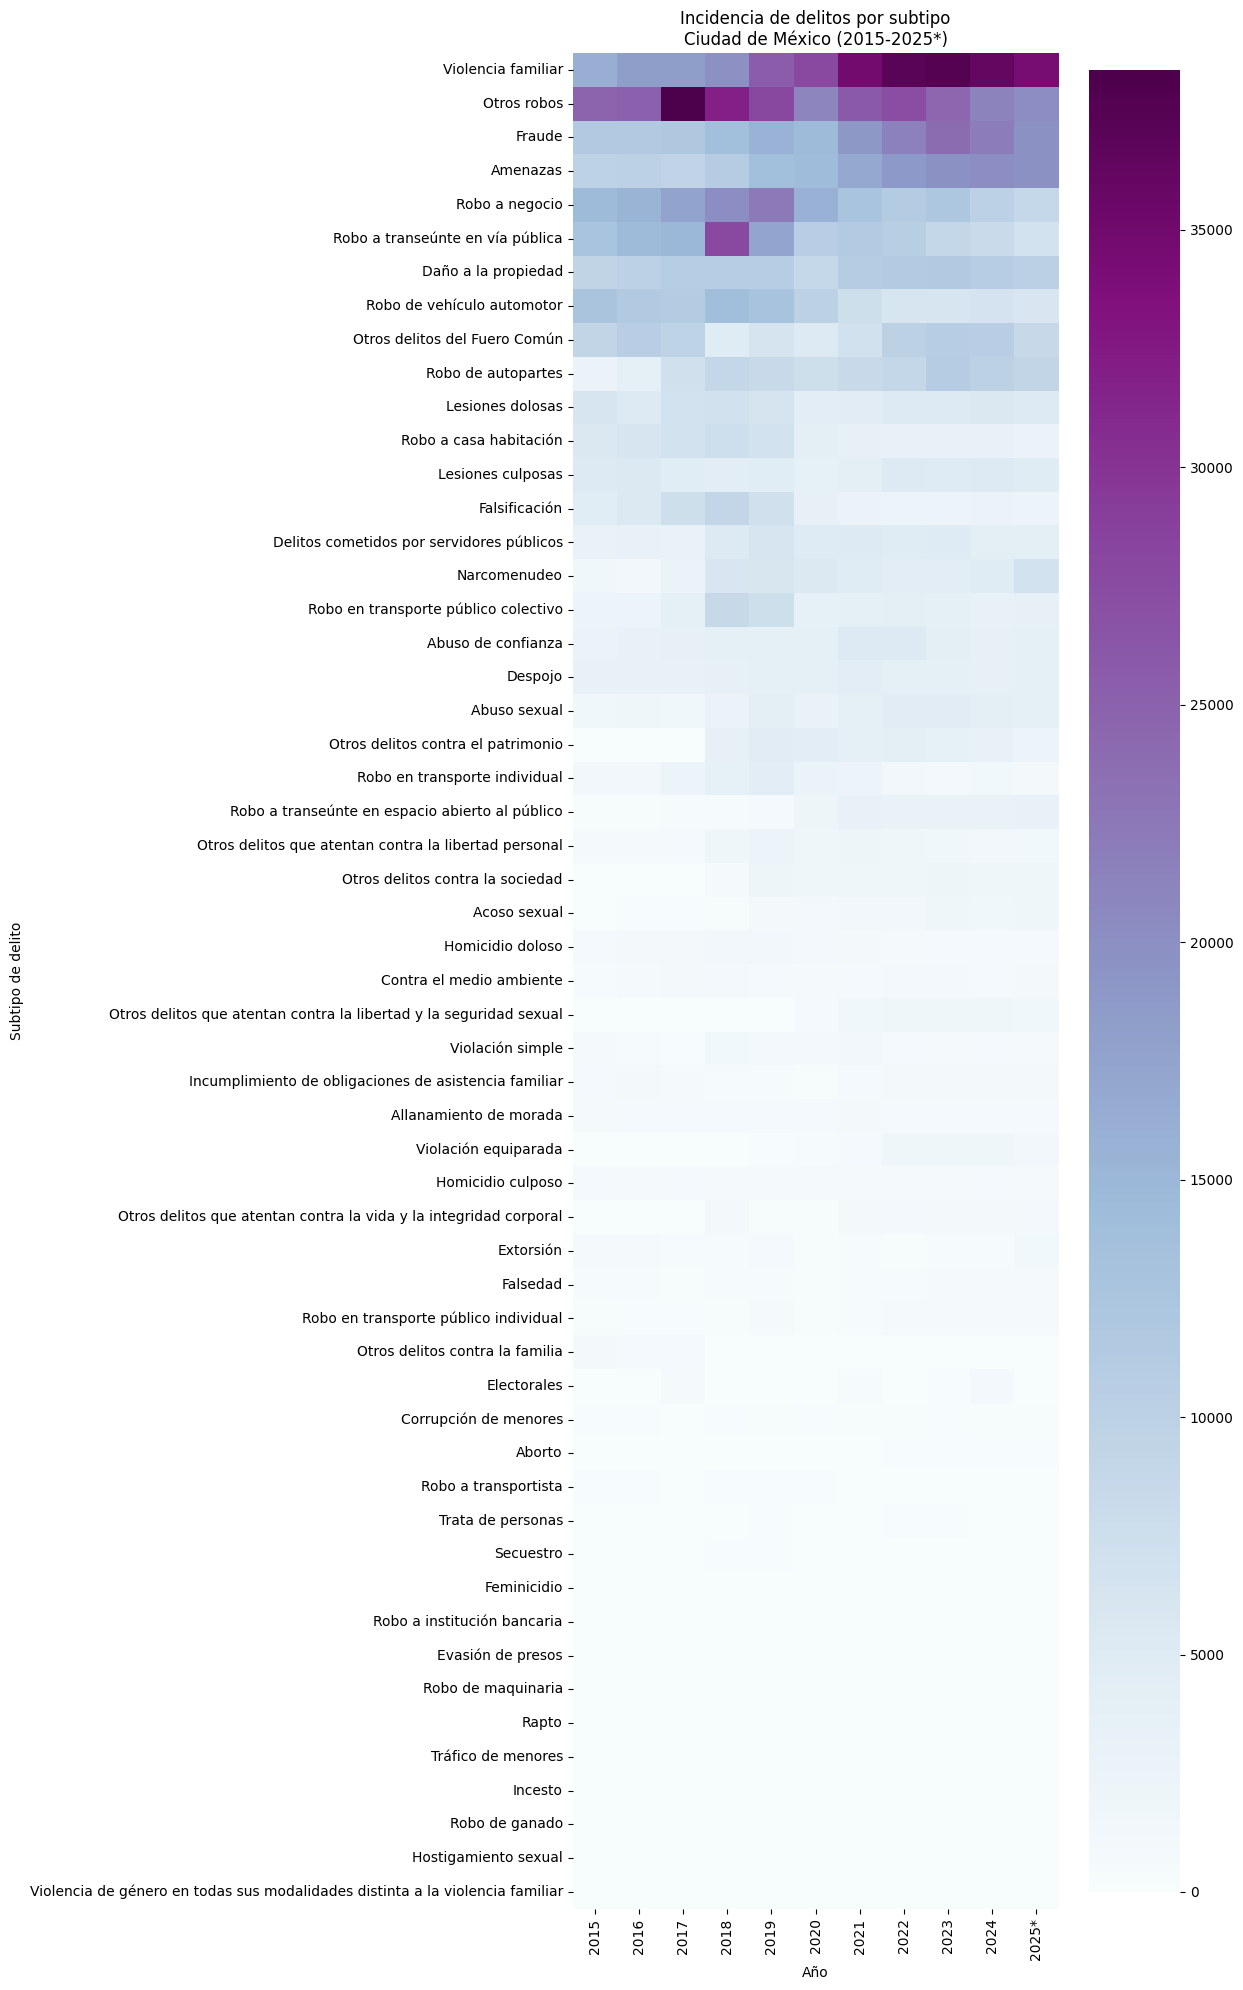

In [427]:
reporte10 = delitos_cdmx[["Año", "Subtipo de delito", "Total"]].groupby(["Año", "Subtipo de delito"]).sum().unstack().droplevel(axis=1, level=0).T
reporte10[2025] = reporte10[2025] * 2
columns = list(reporte10.columns)
years = pandas.Series(columns)
columns[-1] = "2025*"
reporte10.columns = columns
reporte10p = reporte10.copy()
# reporte10p = reporte10p.div(reporte10.max(axis=1), axis=0)
reporte10p["Total"] = reporte10p.sum(axis=1)
# reporte10["Total"] = reporte10.add(1).multiply(years - 2014).sum()
reporte10p = reporte10p.sort_values("Total", ascending=False)
reporte10p = reporte10p.iloc[:, :-1]
reporte10 = reporte10.loc[reporte10p.index]
reporte10.to_csv("conjuntos/reporte10.csv")
pyplot.figure(figsize=(12, 20))
seaborn.heatmap(reporte10, cmap="BuPu")
pyplot.title(f"Incidencia de delitos por subtipo\nCiudad de México (2015-2025*)")
pyplot.xlabel("Año")
pyplot.xticks(rotation=90)
pyplot.tight_layout()
pyplot.savefig(f"figuras/reporte10.png")
pyplot.show()

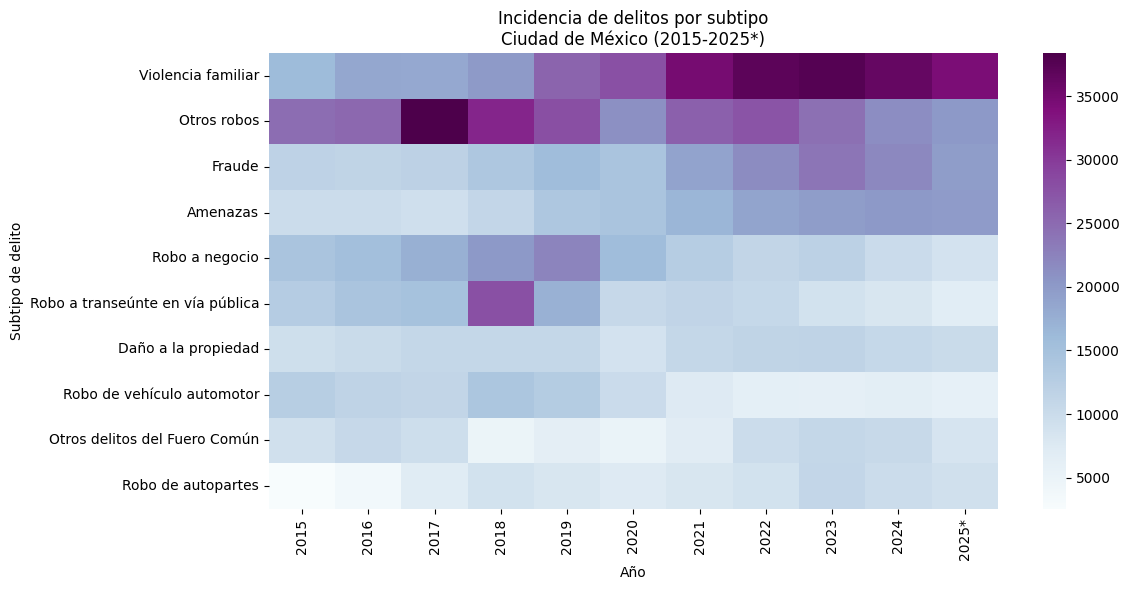

In [428]:
reporte10b = delitos_cdmx[["Año", "Subtipo de delito", "Total"]].groupby(["Año", "Subtipo de delito"]).sum().unstack().droplevel(axis=1, level=0).T
reporte10b[2025] = reporte10b[2025] * 2
columns = list(reporte10b.columns)
years = pandas.Series(columns)
columns[-1] = "2025*"
reporte10b.columns = columns
reporte10bp = reporte10b.copy()
# reporte10bp = reporte10bp.div(reporte10b.max(axis=1), axis=0)
reporte10bp["Total"] = reporte10bp.sum(axis=1)
# reporte10b["Total"] = reporte10b.add(1).multiply(years - 2014).sum()
reporte10bp = reporte10bp.sort_values("Total", ascending=False)
reporte10bp = reporte10bp.iloc[:, :-1]
reporte10b = reporte10b.loc[reporte10bp.index]
pyplot.figure(figsize=(12, 6))
seaborn.heatmap(reporte10b.head(10), cmap="BuPu")
pyplot.title(f"Incidencia de delitos por subtipo\nCiudad de México (2015-2025*)")
pyplot.xlabel("Año")
pyplot.xticks(rotation=90)
pyplot.tight_layout()
pyplot.savefig(f"figuras/reporte10b.png")
pyplot.show()

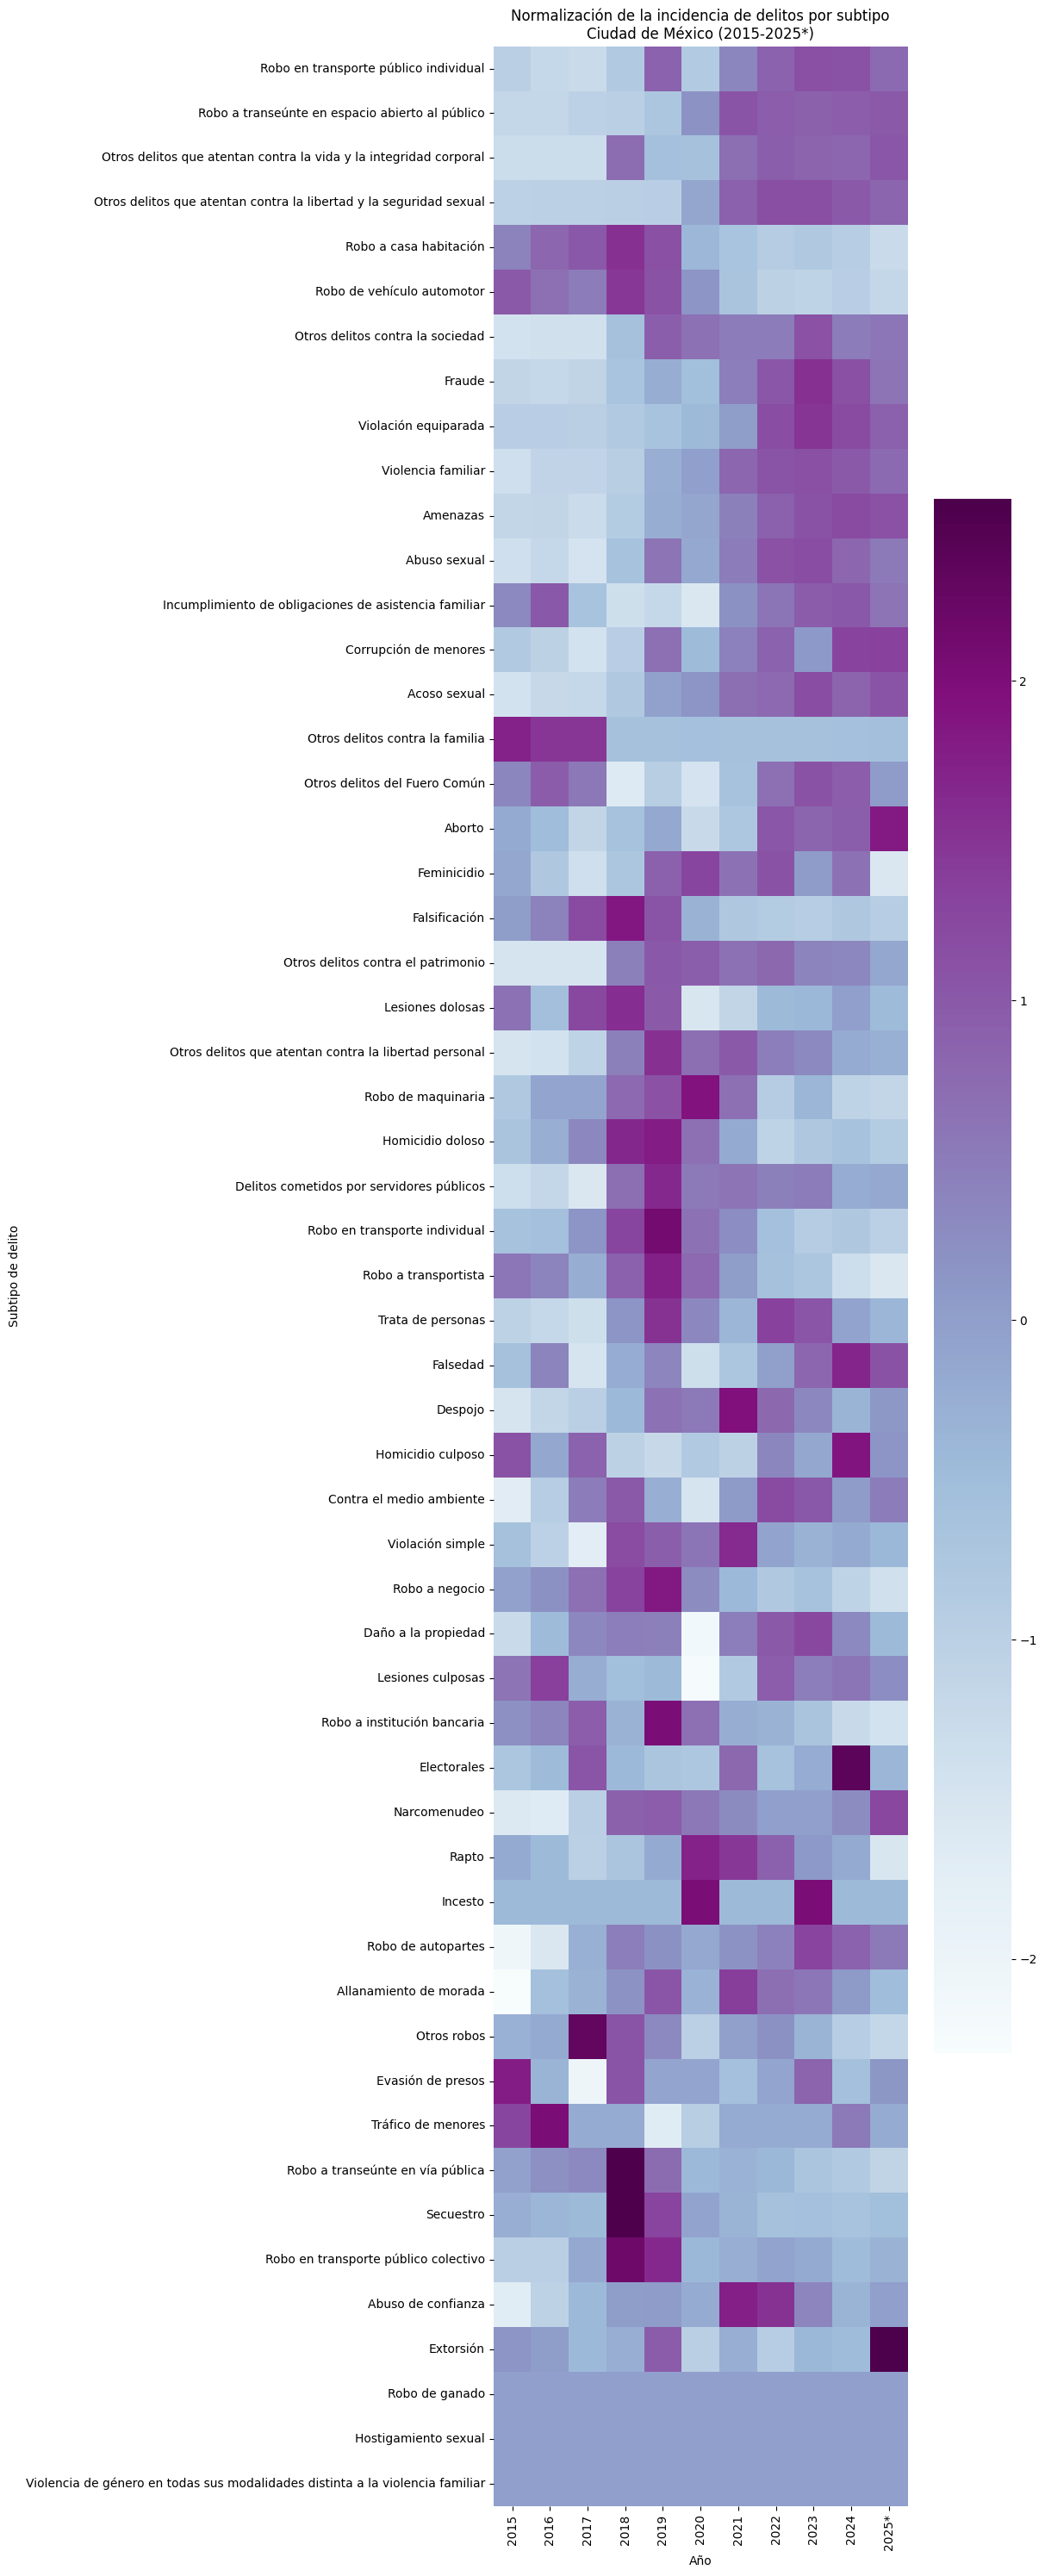

In [429]:
reporte11 = delitos_cdmx[["Año", "Subtipo de delito", "Total"]].groupby(["Año", "Subtipo de delito"]).sum().unstack().droplevel(axis=1, level=0).T
reporte11[2025] = reporte11[2025] * 2
columns = list(reporte11.columns)
years = pandas.Series(columns)
columns[-1] = "2025*"
reporte11.columns = columns
reporte11p = reporte11.copy()
# reporte11p = reporte11p.div(reporte11.sum(axis=1), axis=0)
reporte11p = (reporte11 - reporte11.mean(axis=1).values[:, None]) / reporte11.std(axis=1).values[:, None]
# reporte11p["Total"] = reporte11p.abs().sum(axis=1) +  reporte11p.abs().sum(axis=1) * (reporte11p.sum(axis=1) > 0) * 100
reporte11p["Total"] = reporte11p.abs().sum(axis=1)
# reporte11["Total"] = reporte11.add(1).multiply(years - 2014).sum()
reporte11p = reporte11p.fillna(0).sort_values("Total", ascending=False)
reporte11p = reporte11p.iloc[:, :-1]
reporte11 = reporte11.loc[reporte11p.index]
reporte11p.to_csv("conjuntos/reporte11.csv")
pyplot.figure(figsize=(12, 30))
seaborn.heatmap(reporte11p, cmap="BuPu")
pyplot.title(f"Normalización de la incidencia de delitos por subtipo\nCiudad de México (2015-2025*)")
pyplot.xlabel("Año")
pyplot.xticks(rotation=90)
pyplot.tight_layout()
pyplot.savefig(f"figuras/reporte11.png")
pyplot.show()

Se observa que algunos tipos de delitos aumentaron después de la pandemia respecto a su media, mientras otros incrementaron consistentemente desde el 2018 como el narcomenudeo y los feminicidios, y algunos otros se acentuaron mucho cerca del 2025 como la extorsión y los delitos electorales (este último por las elecciones de 2024 en donde hubieron más incidencias que en otros años).

## Fase 3 - Análisis geográfico

In [452]:
delitos_municipios = delitos[["Cve. Municipio", "Total"]].groupby("Cve. Municipio").sum()
delitos_municipios

,Total
Cve. Municipio,
1001,278371
1002,7121
1003,8541
1004,2941
1005,29892
...,...
32054,730
32055,4201
32056,52432


In [524]:
poblacion = pandas.read_csv("conjuntos/poblacion.csv")

poblacion["CVE"] = poblacion["clave_entidad"].map(str).add(poblacion["clave_municipio"].astype(str).map(lambda s: f"{s:>03s}")).astype(int)

municipios = poblacion[["CVE", "latitud", "longitud"]].set_index("CVE")

municipios["latitud"] = municipios["latitud"]
municipios["longitud"] = municipios["longitud"]

municipios

,latitud,longitud
CVE,,
1001,21.524736,-102.174577
1002,22.141794,-102.052139
1003,21.504887,-102.430750
1004,22.215907,-102.180016
1005,21.574058,-102.203630
...,...,...
32054,22.212552,-101.424536
32055,22.211533,-102.530141
32056,22.463395,-102.341861


In [525]:
delitos_geo = delitos_municipios.join(municipios)
delitos_geo

,Total,latitud,longitud
Cve. Municipio,,,
1001,278371,21.524736,-102.174577
1002,7121,22.141794,-102.052139
1003,8541,21.504887,-102.430750
1004,2941,22.215907,-102.180016
1005,29892,21.574058,-102.203630
...,...,...,...
32054,730,22.212552,-101.424536
32055,4201,22.211533,-102.530141
32056,52432,22.463395,-102.341861


In [526]:
mapa = folium.Map(
    location=(22.33, -99.10),
    zoom_start=5,
    tiles="CartoDB Positron"
)

HeatMap(
    delitos_geo[["latitud", "longitud"]].dropna(),
    blur=True,
    radius=5,
).add_to(mapa)

mapa

In [527]:
delitos_cdmx

,id,Mes,Total,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Mes_num,grupo_delito
0,25970,Enero,4,2015,9,Ciudad de México,9002,Azcapotzalco,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego,1,Homicidios
1,25971,Enero,1,2015,9,Ciudad de México,9002,Azcapotzalco,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma blanca,1,Homicidios
2,25972,Enero,2,2015,9,Ciudad de México,9002,Azcapotzalco,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con otro elemento,1,Homicidios
3,25973,Enero,0,2015,9,Ciudad de México,9002,Azcapotzalco,La vida y la Integridad corporal,Homicidio,Homicidio doloso,No especificado,1,Homicidios
4,25974,Enero,0,2015,9,Ciudad de México,9002,Azcapotzalco,La vida y la Integridad corporal,Homicidio,Homicidio culposo,Con arma de fuego,1,Homicidios
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219907,2347977,Diciembre,0,2025,9,Ciudad de México,9998,No Especificado,Otros bienes jurídicos afectados (del fuero co...,Falsificación,Falsificación,Falsificación,12,Fraude
219908,2347978,Diciembre,0,2025,9,Ciudad de México,9998,No Especificado,Otros bienes jurídicos afectados (del fuero co...,Contra el medio ambiente,Contra el medio ambiente,Contra el medio ambiente,12,Ambiente
219909,2347979,Diciembre,0,2025,9,Ciudad de México,9998,No Especificado,Otros bienes jurídicos afectados (del fuero co...,Delitos cometidos por servidores públicos,Delitos cometidos por servidores públicos,Delitos cometidos por servidores públicos,12,Gobierno
219910,2347980,Diciembre,0,2025,9,Ciudad de México,9998,No Especificado,Otros bienes jurídicos afectados (del fuero co...,Electorales,Electorales,Electorales,12,Gobierno


In [528]:
delitos_cdmx_cond = delitos_cdmx[["Cve. Municipio", "Total"]].groupby("Cve. Municipio").sum()
delitos_cdmx_cond

,Total
Cve. Municipio,
9002,108480
9003,155173
9004,36331
9005,226710
9006,97760
9007,329603
9008,39872
9009,19627
9010,151245


In [529]:
delitos_geo_cdmx = delitos_cdmx_cond.join(municipios).dropna()
delitos_geo_cdmx

,Total,latitud,longitud
Cve. Municipio,,,
9002,108480,19.290277,-99.110370
9003,155173,19.210077,-99.094372
9004,36331,19.212646,-99.175925
9005,226710,19.285860,-99.064849
9006,97760,19.234524,-99.055141
9007,329603,19.213241,-99.053344
9008,39872,19.181763,-99.142946
9009,19627,19.112850,-99.012414
9010,151245,19.232690,-99.114349


In [532]:
mapa_cdmx = folium.Map(
    location=(19.33, -99.10),
    zoom_start=11,
    tiles="CartoDB Positron"
)

HeatMap(
    delitos_geo_cdmx[["latitud", "longitud"]],
    blur=True,
    radius=5,
).add_to(mapa_cdmx)

mapa_cdmx